# Face Recognition 

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import os
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import local_binary_pattern as LBP

## Load Folder

In [2]:
def load_images(data_path):
    images = []
    labels = []

    for person_name in os.listdir(data_path):
        person_dir = os.path.join(data_path, person_name)
        if os.path.isdir(person_dir):
            for image_filename in os.listdir(person_dir):
                if image_filename.endswith('.jpg'):
                    image_path = os.path.join(person_dir, image_filename)
                    image = cv2.imread(image_path)

                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    images.append(image)

                    labels.append(person_name)

    images = np.array(images)
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    
    return {
        'data': images,
        'target': labels,
        'target_names': unique_labels
    }

dataset = load_images('./Data/')

In [3]:
# BACKUP
lfw_dataset = dataset.copy()


print("Shape of images:", lfw_dataset['data'].shape)
print("Shape of labels:", lfw_dataset['target'].shape)
print("Unique labels:", lfw_dataset['target_names'].shape)

Shape of images: (13233, 250, 250, 3)
Shape of labels: (13233,)
Unique labels: (5749,)


## Data Visualization

### Image Distribuition of Top 20 People

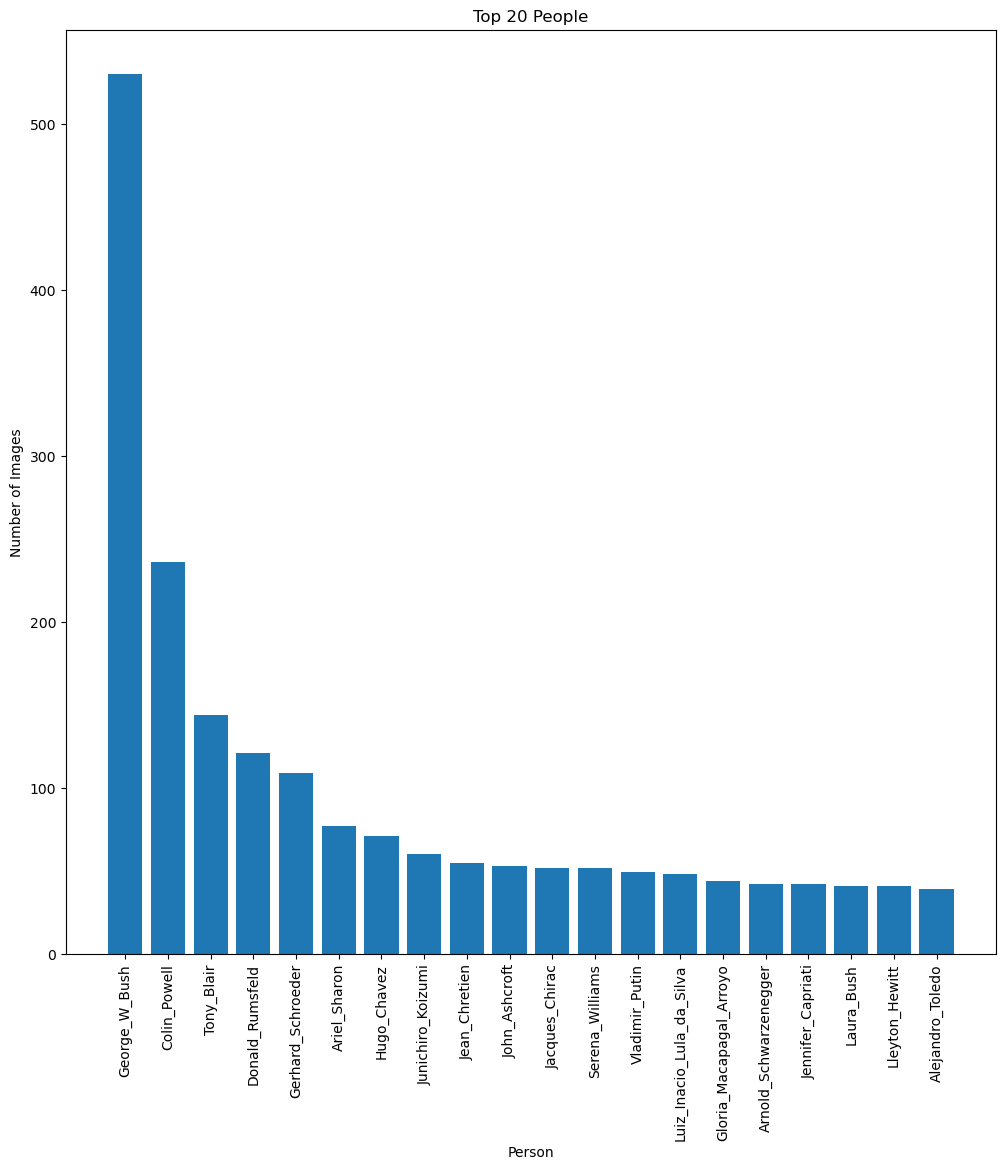

In [4]:
target_counts = Counter(dataset['target'])

top_20_people = target_counts.most_common(20)

plt.figure(figsize=(12, 12))
plt.bar(*zip(*top_20_people))
plt.xlabel('Person')
plt.xticks(rotation=90)
plt.ylabel('Number of Images')
plt.title('Top 20 People')
plt.show()

### Histogram

In [5]:
ranges = [(1, 1), (2, 5), (6, 10), (11, 20), (21, 30), (31, 80), (81, np.inf)]
labels = ['1', '2-5', '6-10', '11-20', '21-30', '31-80', '>81']

people_counts = [0] * len(ranges)
image_counts = [0] * len(ranges)

# For each person, increment the count for the appropriate range
for person, count in target_counts.items():
    for i, (min_count, max_count) in enumerate(ranges):
        if min_count <= count <= max_count:
            people_counts[i] += 1
            image_counts[i] += count
            break

# Calculate the percentages
total_people = sum(people_counts)
total_images = sum(image_counts)
people_percentages = [f"{count / total_people * 100:.2f}" for count in people_counts]
images_percentages = [f"{count / total_images * 100:.2f}" for count in image_counts]

# Create a DataFrame
df = pd.DataFrame({
    '# of images /person': labels,
    '# of people': people_counts,
    '% of people': people_percentages,
    '# of images': image_counts,
    '% of images': images_percentages
})

df

,# of images /person,# of people,% of people,# of images,% of images
0,1,4069,70.78,4069,30.75
1,2-5,1369,23.81,3739,28.26
2,6-10,168,2.92,1251,9.45
3,11-20,86,1.50,1251,9.45
4,21-30,25,0.43,613,4.63
5,31-80,27,0.47,1170,8.84
6,>81,5,0.09,1140,8.61


### Distribuition of Pixel Values

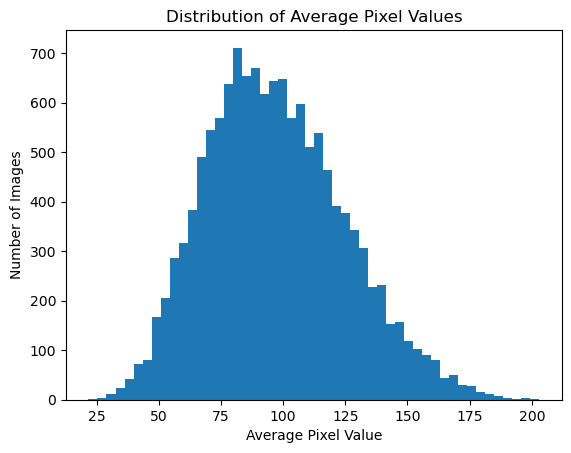

In [6]:
# Distribuition of Pixel Values

# Get the average pixel values for each image
average_pixels = np.mean(dataset['data'], axis=(1, 2, 3))

# Plot the distribution of average pixel values with 50 bins
plt.hist(average_pixels, bins=50)  # Change the number of bins to 50
plt.xlabel('Average Pixel Value')
plt.ylabel('Number of Images')
plt.title('Distribution of Average Pixel Values')

plt.show()

### Plot Some Images

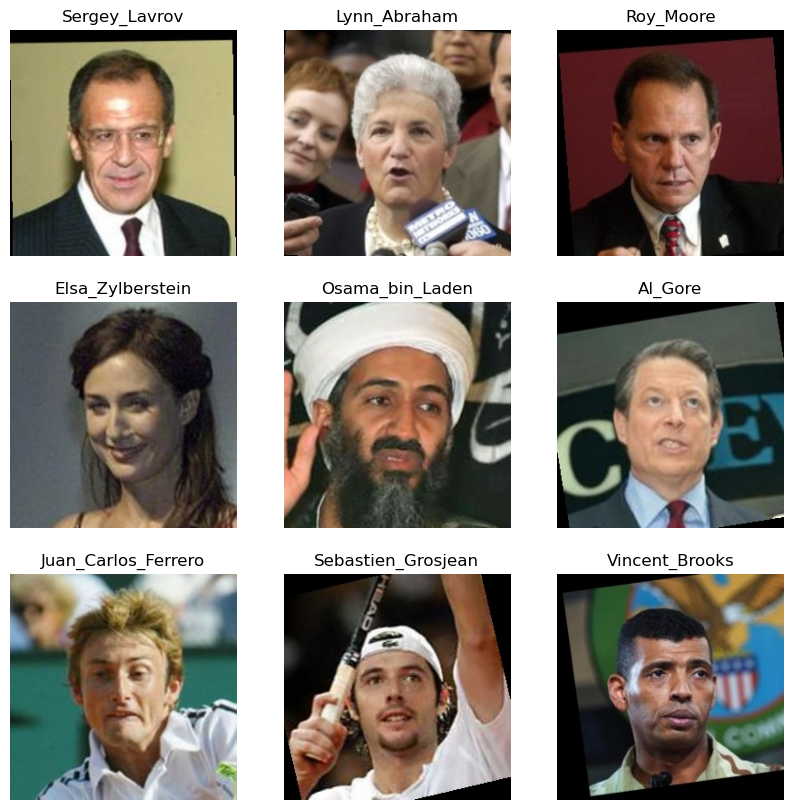

In [7]:
# Function to display a random set of images

def display_random_images(images, labels, rows, cols, cmap=None):
    fig = plt.figure(figsize=(10, 10))

    for i in range(1, cols * rows + 1):
        index = np.random.randint(len(images))
        plt.subplot(rows, cols, i)
        plt.axis('off')
        plt.imshow(images[index], cmap=cmap)
        plt.title(labels[index])

    plt.show()

display_random_images(dataset['data'], dataset['target'], 3, 3)

## Data Preprocessing

### Image Resizing

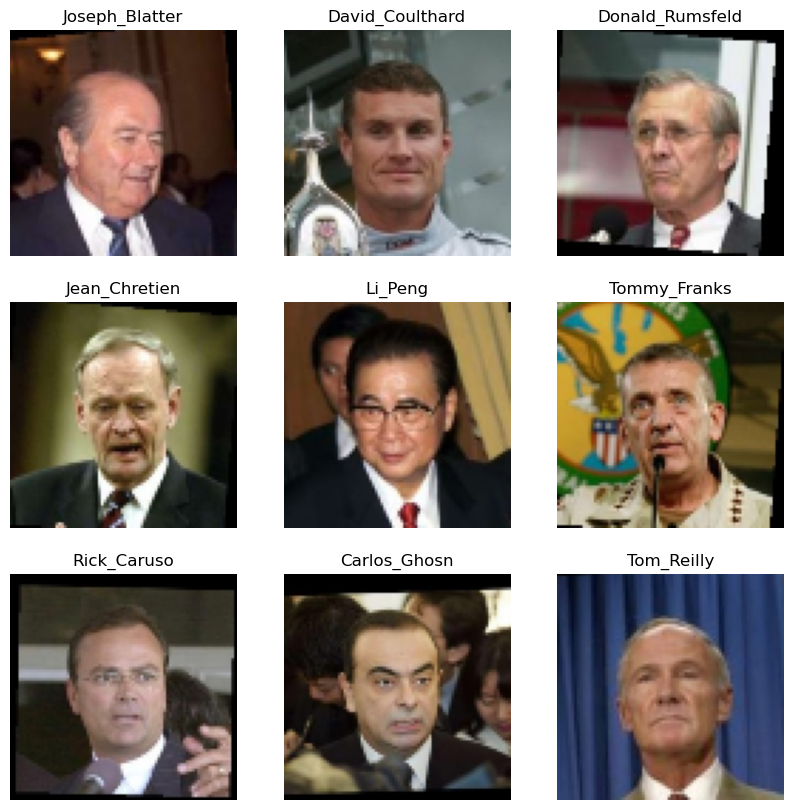

In [8]:
def resize_image(images, target_size=(100, 100)):
    resized_images = [cv2.resize(image, target_size) for image in images]
    return np.array(resized_images)

resized_images = resize_image(dataset['data'], target_size=(80, 80))


display_random_images(resized_images, dataset['target'], 3, 3)

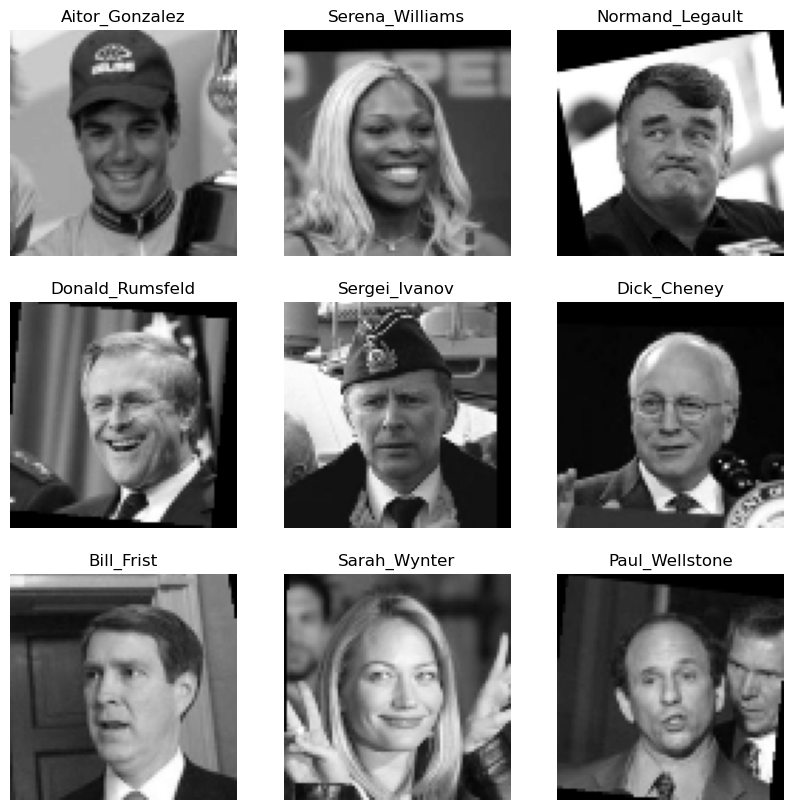

In [9]:
# Gray scale
def gray_scale(images):
    gray_images = [cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in images]
    return np.array(gray_images)

gray_images = gray_scale(resized_images)

display_random_images(gray_images, dataset['target'], 3, 3, cmap='gray')

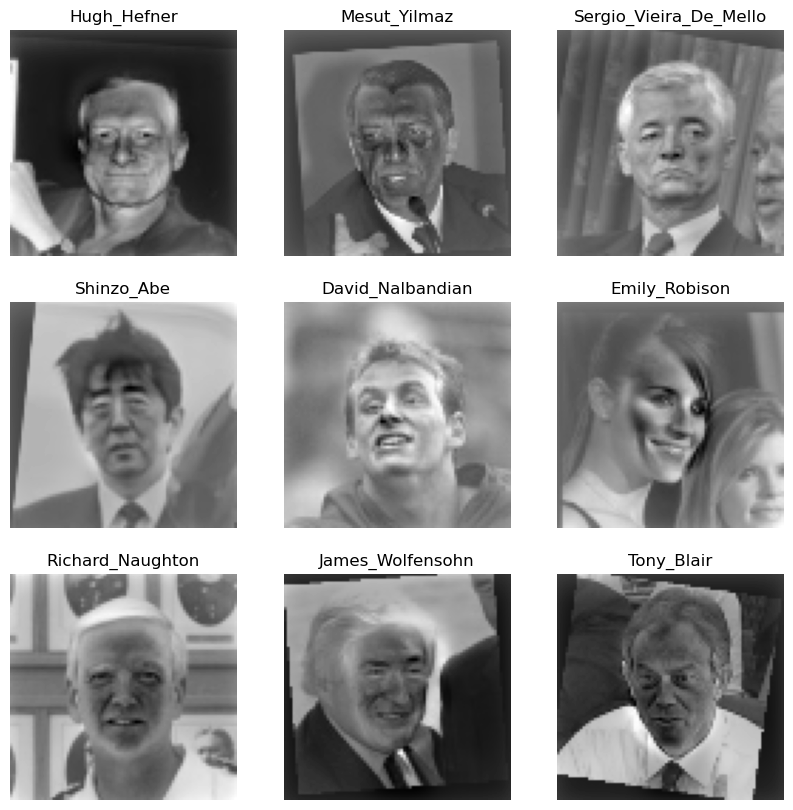

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_images = scaler.fit_transform(gray_images.reshape(-1, 80 * 80)).reshape(-1, 80, 80)

display_random_images(scaled_images, dataset['target'], 3, 3, cmap='gray')

## Feature Extractions

In [11]:
def filter_dataset(dataset, min_faces_per_person):
    # Count the number of images for each person
    target_counts = Counter(dataset['target'])

    # Initialize the filtered dataset
    filtered_dataset = {
        'data': [],
        'target': [],
        'target_names': set()
    }

    # For each image and its corresponding label
    for image, label in zip(dataset['data'], dataset['target']):
        # If this person has at least min_faces_per_person images
        if target_counts[label] >= min_faces_per_person:
            # Add this image and label to the filtered dataset
            filtered_dataset['data'].append(image)
            filtered_dataset['target'].append(label)
            filtered_dataset['target_names'].add(label)

    filtered_dataset['data'] = np.array(filtered_dataset['data'])
    filtered_dataset['target'] = np.array(filtered_dataset['target'])
    filtered_dataset['target_names'] = np.array(list(filtered_dataset['target_names']))

    return filtered_dataset

dataset['data'] = scaled_images

filtered_dataset = filter_dataset(dataset, min_faces_per_person=20)

In [12]:
filtered_dataset['data'].shape
filtered_dataset['target'].shape


print("Shape of images:", filtered_dataset['data'].shape)

Shape of images: (3023, 80, 80)


### TRAIN-TEST-SPLIT

In [13]:
X = filtered_dataset['data']
y = filtered_dataset['target']

X = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2418, 6400)
Shape of X_test: (605, 6400)
Shape of y_train: (2418,)
Shape of y_test: (605,)


### Principal Component Analysis (Eigenfaces)

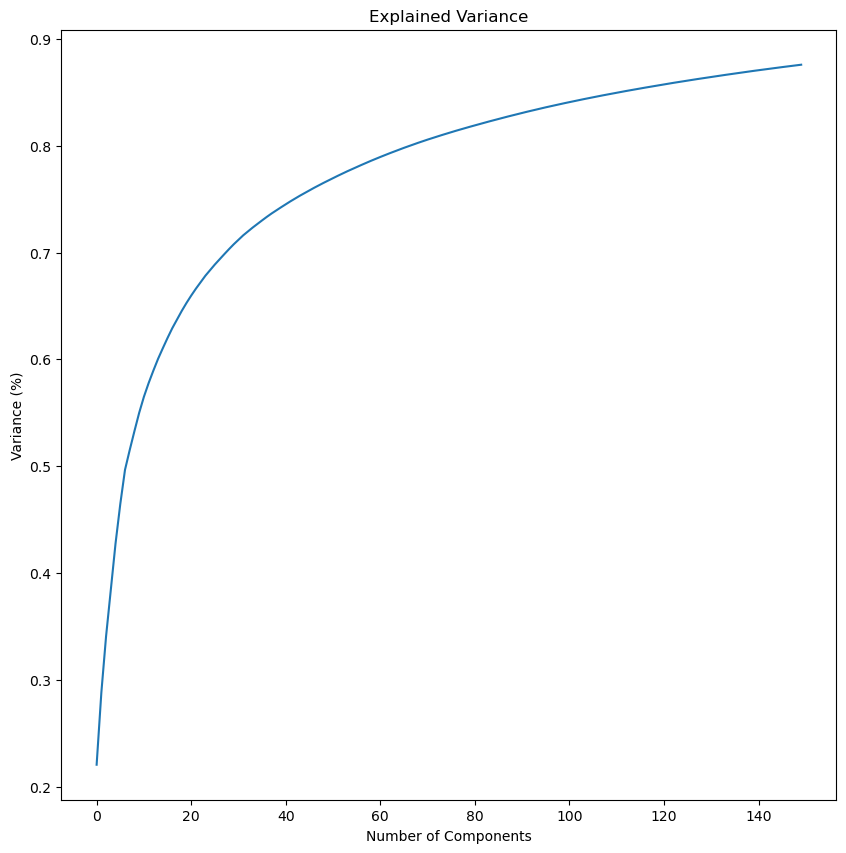

In [14]:
def pca_transform(X_train, X_test, n_components=None):
    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, pca

X_train_pca, X_test_pca, pca = pca_transform(X_train, X_test, n_components=150)

# Function to plot the explained variance ratio
plt.figure(figsize=(10, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

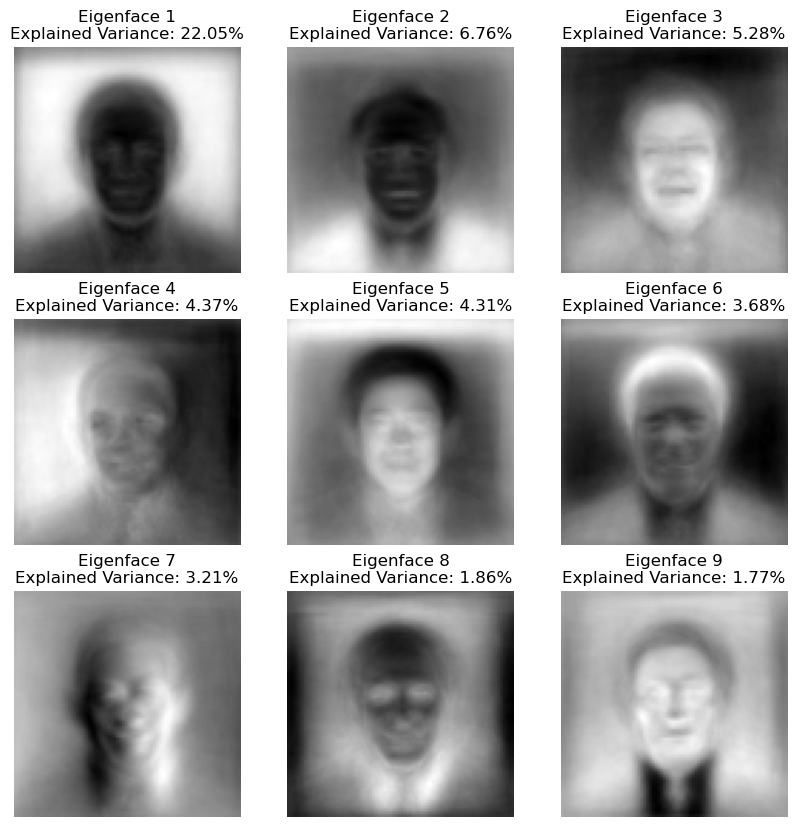

In [15]:
# Assuming pca is your PCA object and X_train is your training data
# Calculate explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the eigenfaces with information in the title
def plot_eigenfaces(components, h, w, rows, cols, explained_variance_ratio):
    plt.figure(figsize=(10, 10))

    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(components[i].reshape((h, w)), cmap='gray')
        plt.title(f'Eigenface {i + 1}\nExplained Variance: {explained_variance_ratio[i]*100:.2f}%')
        plt.axis('off')

    plt.show()

# Assuming your images have dimensions 80x80, adjust as needed
plot_eigenfaces(pca.components_, 80, 80, 3, 3, explained_variance_ratio)

### Linear Discriminant Analysis (LDA)

In [16]:
def lda_transform(X_train, y_train, X_test, n_components=None):
    lda = LDA(n_components=n_components)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)
    return X_train_lda, X_test_lda

X_train_lda, X_test_lda = lda_transform(X_train, y_train, X_test)

### Local Binary Pattern

In [17]:
from skimage import feature

def lbp_transform(images, radius=3, n_points=8):
    transformed_images = []

    for image in images:
        lbp = feature.local_binary_pattern(image, n_points, radius, method='uniform')
        transformed_images.append(lbp.flatten())

    return np.array(transformed_images)

X_train_lbp = lbp_transform(X_train.reshape(-1, 80, 80))
X_test_lbp = lbp_transform(X_test.reshape(-1, 80, 80))

c:\Users\yokiclearwater\miniconda3\envs\data_science\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


### Discrete Cosine Transform

In [18]:
# DCT Transform
def dct_transform(images):
    transformed_images = []

    for image in images:
        dct = cv2.dct(image)
        transformed_images.append(dct.flatten())

    return np.array(transformed_images)

X_train_dct = dct_transform(X_train.reshape(-1, 80, 80))
X_test_dct = dct_transform(X_test.reshape(-1, 80, 80))

## Model Training

In [19]:
# Accuracy List
from sklearn import clone
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


models_accuracy = {}

# Define the models
svm_clf = SVC(kernel='rbf', C=1000, gamma=0.001, random_state=42, class_weight='balanced')
lda_clf = LDA()
rf_clf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_depth=20, bootstrap=False, random_state=42, class_weight='balanced')
lr_clf = LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', max_iter=400, C=0.01)
knn_clf = KNeighborsClassifier(weights='uniform', n_neighbors=11, metric='euclidean')


# Define feature extraction methods
feature_extraction_methods = {'PCA', 'LDA', 'LBP', 'DCT'}

# Initialize dictionaries to store the models
models = {}

# Loop through models
for model, model_name in zip([svm_clf, lda_clf, lr_clf, knn_clf], ['SVM', 'LDA', 'LR', 'KNN']):
    # Loop through feature extraction methods
    for method in feature_extraction_methods:
        # Choose feature extraction method
        if method == 'PCA':
            X_train_transformed = X_train_pca
            X_test_transformed = X_test_pca
        elif method == 'LDA':
            X_train_transformed = X_train_lda
            X_test_transformed = X_test_lda
        elif method == 'LBP':
            X_train_transformed = X_train_lbp
            X_test_transformed = X_test_lbp
        elif method == 'DCT':
            X_train_transformed = X_train_dct
            X_test_transformed = X_test_dct

        # Clone the model to avoid retraining
        cloned_model = clone(model)
        
        # Train the model
        cloned_model.fit(X_train_transformed, y_train)

        # Make predictions on the test set
        y_pred = cloned_model.predict(X_test_transformed)

        # Calculate the accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Store the accuracy in the dictionary
        models_accuracy[f'{model_name}_{method}'] = accuracy
        models[f'{model_name}_{method}'] = cloned_model

        # Print results
        print(f'{model_name} with {method} - Accuracy:', accuracy)

# Display the overall accuracy results
print("Overall Accuracy Results:")
print(models_accuracy)

SVM with PCA - Accuracy: 0.5652892561983471
SVM with LBP - Accuracy: 0.17520661157024794
SVM with LDA - Accuracy: 0.43636363636363634
SVM with DCT - Accuracy: 0.17520661157024794
LDA with PCA - Accuracy: 0.6297520661157024
LDA with LBP - Accuracy: 0.3702479338842975
LDA with LDA - Accuracy: 0.43471074380165287
LDA with DCT - Accuracy: 0.2644628099173554
LR with PCA - Accuracy: 0.5504132231404959
LR with LBP - Accuracy: 0.509090909090909
LR with LDA - Accuracy: 0.43140495867768597
LR with DCT - Accuracy: 0.6264462809917355
KNN with PCA - Accuracy: 0.30578512396694213
KNN with LBP - Accuracy: 0.19008264462809918
KNN with LDA - Accuracy: 0.38181818181818183
KNN with DCT - Accuracy: 0.2528925619834711
Overall Accuracy Results:
{'SVM_PCA': 0.5652892561983471, 'SVM_LBP': 0.17520661157024794, 'SVM_LDA': 0.43636363636363634, 'SVM_DCT': 0.17520661157024794, 'LDA_PCA': 0.6297520661157024, 'LDA_LBP': 0.3702479338842975, 'LDA_LDA': 0.43471074380165287, 'LDA_DCT': 0.2644628099173554, 'LR_PCA': 0.55

In [23]:
# Plot the predict results and its true label
def plot_predict_results(images, true_labels, pred_labels, rows, cols, cmap=None):
    fig = plt.figure(figsize=(8, 8))

    for i in range(1, cols * rows + 1):
        index = np.random.randint(len(images))
        plt.subplot(rows, cols, i)
        plt.axis('off')
        plt.imshow(images[index], cmap=cmap)
        plt.title(f'True: {true_labels[index]}\nPredicted: {pred_labels[index]}')

        # If the prediction is wrong, use red color
        if true_labels[index] != pred_labels[index]:
            plt.title(f'True: {true_labels[index]}\nPredicted: {pred_labels[index]}', color='red')
        else:
            plt.title(f'True: {true_labels[index]}\nPredicted: {pred_labels[index]}', color='green')

    plt.show()

# # Make predictions on the test set
y_pred = models['LDA_PCA'].predict(X_test_pca)

plot_predict_results(X_test.reshape(-1, *original_shape), y_test, y_pred, 3, 3, cmap='gray')

NameError: name 'original_shape' is not defined

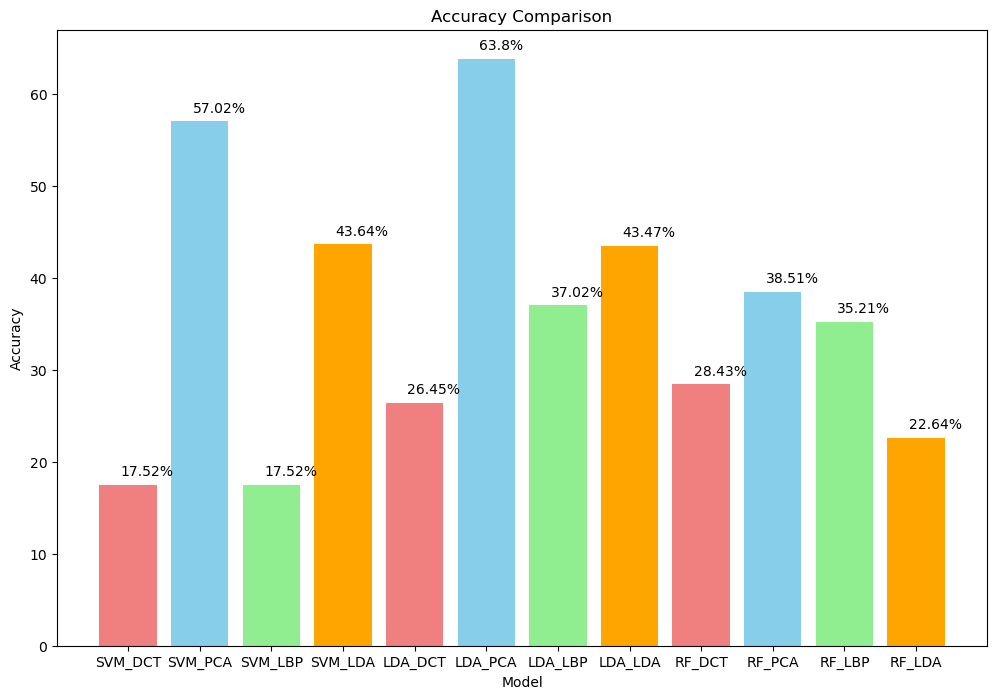

In [ ]:
# Function to plot accuracy results

# Colors RED FOR PCA, BLUE FOR LDA
colors = [
    "skyblue" if model_name.split("_")[1] == "PCA" else
    "lightcoral" if model_name.split("_")[1] == "DCT" else
    "orange" if model_name.split("_")[1] == "LDA" else
    "lightgreen"
    for model_name in models_accuracy.keys()
]

# CHANGE ACCURACY TO % AND Plot
models_accuracy_percentage = {k: v * 100 for k, v in models_accuracy.items()}

plt.figure(figsize=(12, 8))
plt.bar(models_accuracy.keys(), models_accuracy_percentage.values(), color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')

for i, v in enumerate(models_accuracy_percentage.values()):
    plt.text(i - 0.1, v + 1, str(round(v, 2)) + '%')

plt.title('Accuracy Comparison')
plt.show()